Mounted at /content/drive
PyTorch Version: 2.9.0+cu126
Using device: cuda
Preview of the provided annotation DataFrame:
         filename  width  height class_name  xmin  ymin  xmax  ymax
0  10_spur_05.jpg   2240    2016       spur  1258   889  1334   999
1  10_spur_05.jpg   2240    2016       spur  1826  1754  1977  1819
2  10_spur_05.jpg   2240    2016       spur   977   429  1058   550
3  10_spur_05.jpg   2240    2016       spur  1482  1276  1539  1376
4  10_spur_05.jpg   2240    2016       spur  1666   587  1766   658

6 classes detected in the DataFrame: ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']
Number of defects - Train: 2043, Validation: 457, Test: 453
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


Epoch 1/50 | ----------
Train Loss: 0.4310 Acc: 0.8453
Val Loss: 0.1072 Acc: 0.9672
Validation loss improved (inf -> 0.1072). Saving model...

Epoch 2/50 | ----------
Train Loss: 0.1624 Acc: 0.9486
Val Loss: 0.1225 Acc: 0.9716

Epoch 3/50 | ----------
Train Loss: 0.0874 Acc: 0.9726
Val Loss: 0.0199 Acc: 0.9978
Validation loss improved (0.1072 -> 0.0199). Saving model...

Epoch 4/50 | ----------
Train Loss: 0.0639 Acc: 0.9775
Val Loss: 0.0190 Acc: 0.9956
Validation loss improved (0.0199 -> 0.0190). Saving model...

Epoch 5/50 | ----------
Train Loss: 0.0518 Acc: 0.9824
Val Loss: 0.0433 Acc: 0.9847

Epoch 6/50 | ----------
Train Loss: 0.0624 Acc: 0.9804
Val Loss: 0.0102 Acc: 0.9978
Validation loss improved (0.0190 -> 0.0102). Saving model...

Epoch 7/50 | ----------
Train Loss: 0.0414 Acc: 0.9868
Val Loss: 0.0111 Acc: 0.9956

Epoch 8/50 | ----------
Train Loss: 0.0784 Acc: 0.9775
Val Loss: 0.0087 Acc: 0.9978
Validation loss improved (0.0102 -> 0.0087). Saving model...

Epoch 9/50 | -----

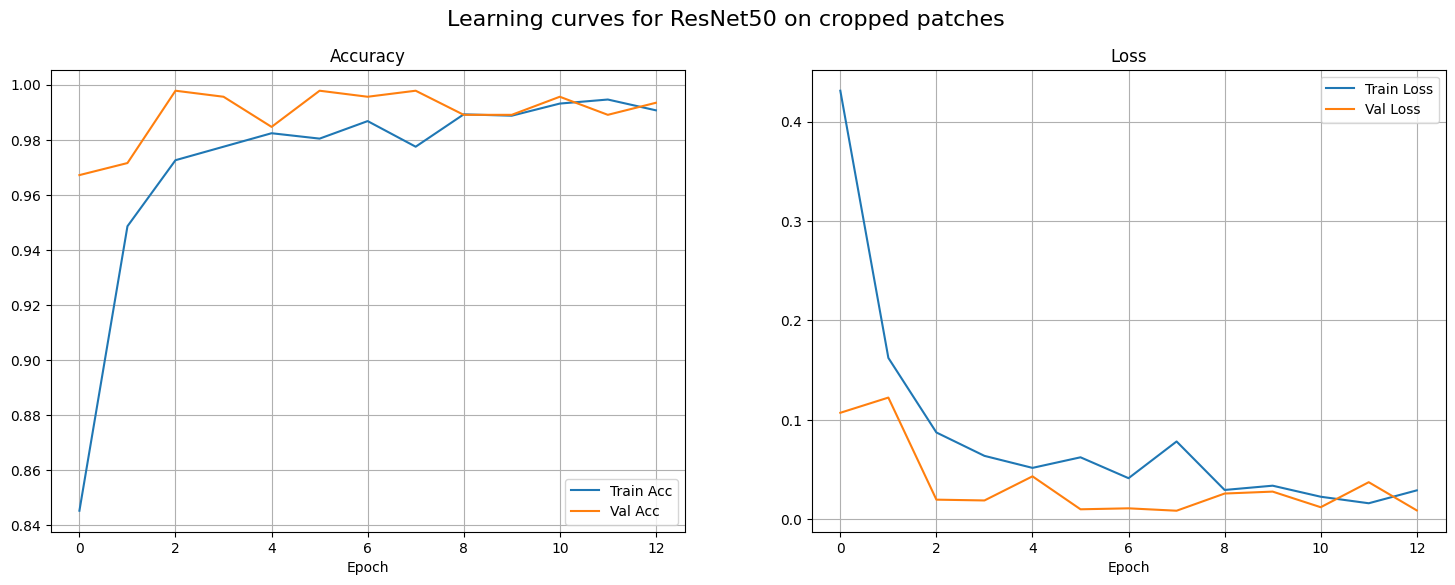


--- Final evaluation of model 'ResNet50' on the Test set ---

                 precision    recall  f1-score   support

   missing_hole     1.0000    1.0000    1.0000        71
     mouse_bite     0.9625    1.0000    0.9809        77
   open_circuit     1.0000    0.9726    0.9861        73
          short     1.0000    0.9846    0.9922        65
           spur     1.0000    0.9579    0.9785        95
spurious_copper     0.9474    1.0000    0.9730        72

       accuracy                         0.9845       453
      macro avg     0.9850    0.9859    0.9851       453
   weighted avg     0.9853    0.9845    0.9846       453



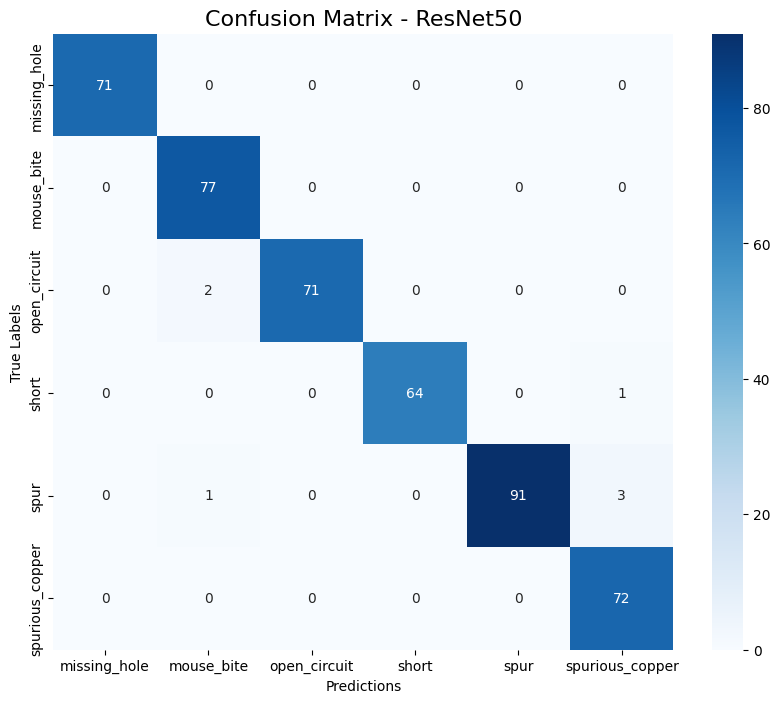

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, utils

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time
import copy
import os
import xml.etree.ElementTree as ET # Import for XML parsing
import re # Import for regex
from google.colab import drive # Import for Google Drive mounting

# Mount Google Drive to ensure access to files
drive.mount('/content/drive')

# Basic configuration
print("PyTorch Version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===================================================================
# 1. DATA PREPARATION (Re-creating df_annot and dataloaders for robustness)
# This section is copied and adapted from previous cells to ensure self-containment.
# ===================================================================

# --- Define directories ---
input_dir='/content/drive/MyDrive/PCB_DATASET/'
annote_dir=os.path.join(input_dir,'Annotations')
destination_dir = "/content/drive/MyDrive/PCB_DATASET/images_combined/"

# Ensure directories exist
if not os.path.exists(annote_dir):
    raise FileNotFoundError(f"Annotation directory not found: {annote_dir}. Please check your Google Drive path and mount status.")
if not os.path.exists(destination_dir):
    print(f"Creating destination directory: {destination_dir}")
    os.makedirs(destination_dir, exist_ok=True)

# --- Parse XML to return Bounding box dimensions (copied from LYIpsp-7PVIc)---
def parse_xml(xml_file):
    data=[]
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })
    return data

# --- Retrieving data for all files (copied from AV0pH46ePX8H and LAk9OIx0PauQ) ---
all_data=[]
type_annot=os.listdir(annote_dir)
for x in type_annot:
    current_annote_subdir = os.path.join(annote_dir, x)
    if os.path.isdir(current_annote_subdir):
        for file in os.listdir(current_annote_subdir):
            if file.endswith('.xml'): # Ensure we only process XML files
                xml_file_path=os.path.join(current_annote_subdir, file)
                data=parse_xml(xml_file_path)
                all_data.extend(data)

df_annot=pd.DataFrame(all_data)

# To avoid conflicts with the Python keyword 'class', rename the column
if 'class' in df_annot.columns:
    df_annot = df_annot.rename(columns={'class': 'class_name'})

print("Preview of the provided annotation DataFrame:")
print(df_annot.head())

# Get the list of classes and number of classes
class_names = sorted(df_annot['class_name'].unique())
num_classes = len(class_names)
print(f"\n{num_classes} classes detected in the DataFrame: {class_names}")

# --- Train/Validation/Test split based on FILE NAMES ---
unique_filenames = df_annot['filename'].unique()
train_files, test_val_files = train_test_split(unique_filenames, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

train_df = df_annot[df_annot['filename'].isin(train_files)].reset_index(drop=True)
val_df = df_annot[df_annot['filename'].isin(val_files)].reset_index(drop=True)
test_df = df_annot[df_annot['filename'].isin(test_files)].reset_index(drop=True)

dataset_sizes = {'train': len(train_df), 'val': len(val_df), 'test': len(test_df)}
print(f"Number of defects - Train: {dataset_sizes['train']}, Validation: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")

# --- Data Augmentation and Normalization ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Standardize patch size
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Custom Dataset class for cropping images ---
class PCBCropDataset(Dataset):
    def __init__(self, dataframe, image_dir, class_names, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['filename']
        box = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
        label_idx = self.class_to_idx[row['class_name']]

        try:
            img_path = os.path.join(self.image_dir, img_filename)
            image = Image.open(img_path).convert('RGB')
            cropped_image = image.crop(box)
        except FileNotFoundError:
            print(f"Warning: File not found {img_path}. Returning an empty tensor.")
            return torch.zeros((3, 224, 224)), -1

        if self.transform:
            cropped_image = self.transform(cropped_image)

        return cropped_image, label_idx

# --- Create datasets and dataloaders ---
batch_size = 16

train_dataset = PCBCropDataset(train_df, destination_dir, class_names, transform=data_transforms['train'])
val_dataset = PCBCropDataset(val_df, destination_dir, class_names, transform=data_transforms['val'])
test_dataset = PCBCropDataset(test_df, destination_dir, class_names, transform=data_transforms['val'])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
}

# ===================================================================
# 2. PRETRAINED MODEL (ResNet50)
# ===================================================================
def get_pretrained_model(num_classes):
    model = models.resnet50(
        weights=models.ResNet50_Weights.IMAGENET1K_V1
    )

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last convolutional block (layer4) and the classification layer (fc)
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True

    # Replace classifier head
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model.to(device)


# ===================================================================
# 3. TRAINING AND VALIDATION FUNCTION
# ===================================================================
def train_model(model, criterion, optimizer, num_epochs=50, patience=5):
    since = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}' + ' | ' + '-'*10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward(); optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val':
                if epoch_loss < best_loss:
                    print(f"Validation loss improved ({best_loss:.4f} -> {epoch_loss:.4f}). Saving model...")
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Validation Loss: {best_loss:4f}')

    model.load_state_dict(best_model_wts)
    return model, history


# ===================================================================
# 4. TRAINING EXECUTION
# ===================================================================
# Clear the GPU cache to ensure memory is free
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Instantiate the model
resnet_model = get_pretrained_model(num_classes)

# Define the loss function and optimizer
class_weights = torch.tensor([1.0] * num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
# Optimize only parameters of the new layer (those that are not frozen)
optimizer = optim.Adam([
    {'params': resnet_model.fc.parameters(), 'lr': 1e-3},
    {'params': resnet_model.layer4.parameters(), 'lr': 1e-4}
])

# Start training
best_resnet_model, history = train_model(resnet_model, criterion, optimizer, num_epochs=50, patience=5)


# ===================================================================
# 5. RESULT ANALYSIS AND EVALUATION
# ===================================================================
# --- Plot learning curves ---
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f"Learning curves for {model_name}", fontsize=16)
    ax1.plot(history['train_acc'], label='Train Acc'); ax1.plot(history['val_acc'], label='Val Acc')
    ax1.set_title('Accuracy'); ax1.set_xlabel('Epoch'); ax1.legend(); ax1.grid(True)
    ax2.plot(history['train_loss'], label='Train Loss'); ax2.plot(history['val_loss'], label='Val Loss')
    ax2.set_title('Loss'); ax2.set_xlabel('Epoch'); ax2.legend(); ax2.grid(True)
    plt.show()

plot_history(history, "ResNet50 on cropped patches")

# --- Evaluation on the test set ---
def evaluate_model(model, dataloader, model_name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\n--- Final evaluation of model '{model_name}' on the Test set ---\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predictions'); plt.ylabel('True Labels')
    plt.show()

evaluate_model(best_resnet_model, dataloaders['test'], "ResNet50")